# Extract regions near Ca H & K lines from HARPS spectra

In [1]:
import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
files = glob.glob('/Volumes/hdd/grant/astro/rawdata/harps/betapic/s1d_A/*s1d_A.fits')
nfiles = len(files)
print('{} files'.format(nfiles))

2153 files


In [3]:
# get one spectrum
def get_spec(file,min_rv=-500, max_rv=500, h_not_k=False, sodium=False):
    '''Return a spectrum.'''
    h = fits.open(file)
    spec = fits.getdata(file)
    wave = h[0].header['CRVAL1'] + np.arange(len(spec))*h[0].header['CDELT1']
    date = h[0].header['MJD-OBS']

    # Ca HK lines
    if h_not_k:
        chk = 3968.47
    else:
        chk = 3933.66
        
    # Sodium D lines
    if sodium:
        if h_not_k:
            chk = 5895.924
        else:
            chk = 5889.95
        
    # normalise near line
    out1 = (chk-1.5 < wave) & (wave < chk-1)
    out2 = (chk+3 < wave) & (wave < chk+3.5)
    norm = np.mean(np.append(spec[out1],spec[out2]))

    rv = ( (wave * u.AA).to(u.km/u.s, equivalencies=u.doppler_optical(chk*u.AA)) - 21*u.km/u.s ).value

    ok = (rv >= min_rv) & (rv <= max_rv)
    return rv[ok], spec[ok]/norm, date

<IPython.core.display.Javascript object>


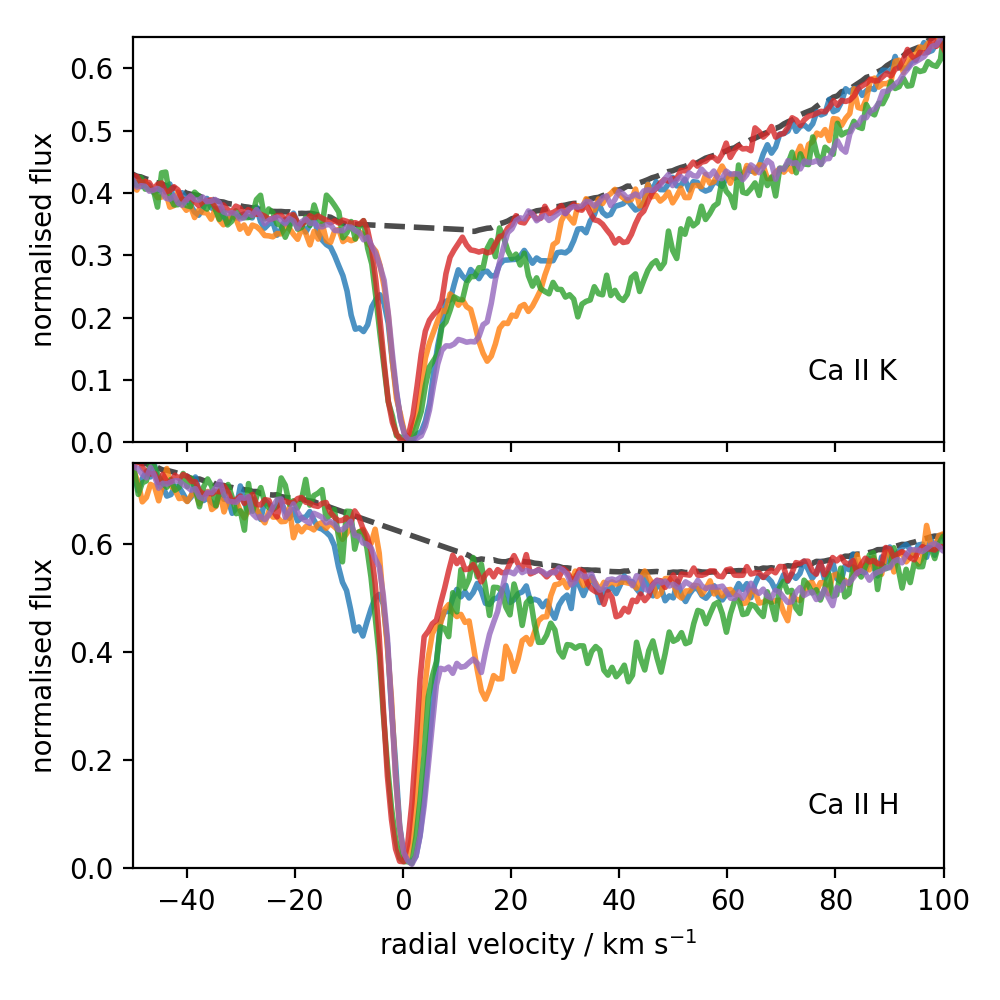

In [51]:
# sample spectra
fig,ax = plt.subplots(2, 1, figsize=(5,5), sharey=False, sharex=True)

# get stellar ref spec
rv,_,_ = get_spec(files[0])
mean_spec_ca_k_nocs = np.load('meanspec-nocs-k.npy')
rv1,_,_ = get_spec(files[0], h_not_k=True)
mean_spec_ca_h_nocs = np.load('meanspec-nocs-h.npy')

ax[0].plot(rv, mean_spec_ca_k_nocs, '--', color='black', linewidth=2, alpha=0.7, zorder=-2)
ax[1].plot(rv1, mean_spec_ca_h_nocs, '--', color='black', linewidth=2, alpha=0.7, zorder=-2)

for i in np.random.randint(nfiles,size=5):
    f = files[i]
    rv,s,date = get_spec(f)
    ax[0].plot(rv,s, linewidth=2, alpha=0.8, zorder=-1)
    rv,s,date = get_spec(f,h_not_k=True)
    ax[1].plot(rv,s, linewidth=2, alpha=0.8, zorder=-1)

ax[0].text(75,0.1,'Ca II K')    
ax[1].text(75,0.1,'Ca II H')    

ax[0].set_ylabel('normalised flux')
ax[1].set_ylabel('normalised flux')

ax[1].set_xlabel('radial velocity / km s$^{-1}$')
ax[0].set_xlim(-50,100)
ax[0].set_ylim(0,0.65)
ax[1].set_ylim(0,0.75)

for a in ax:
    a.set_rasterization_zorder(0)

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
fig.savefig('/Users/grant/astro/doc/feb-accel/ca.eps', dpi=100)

<IPython.core.display.Javascript object>


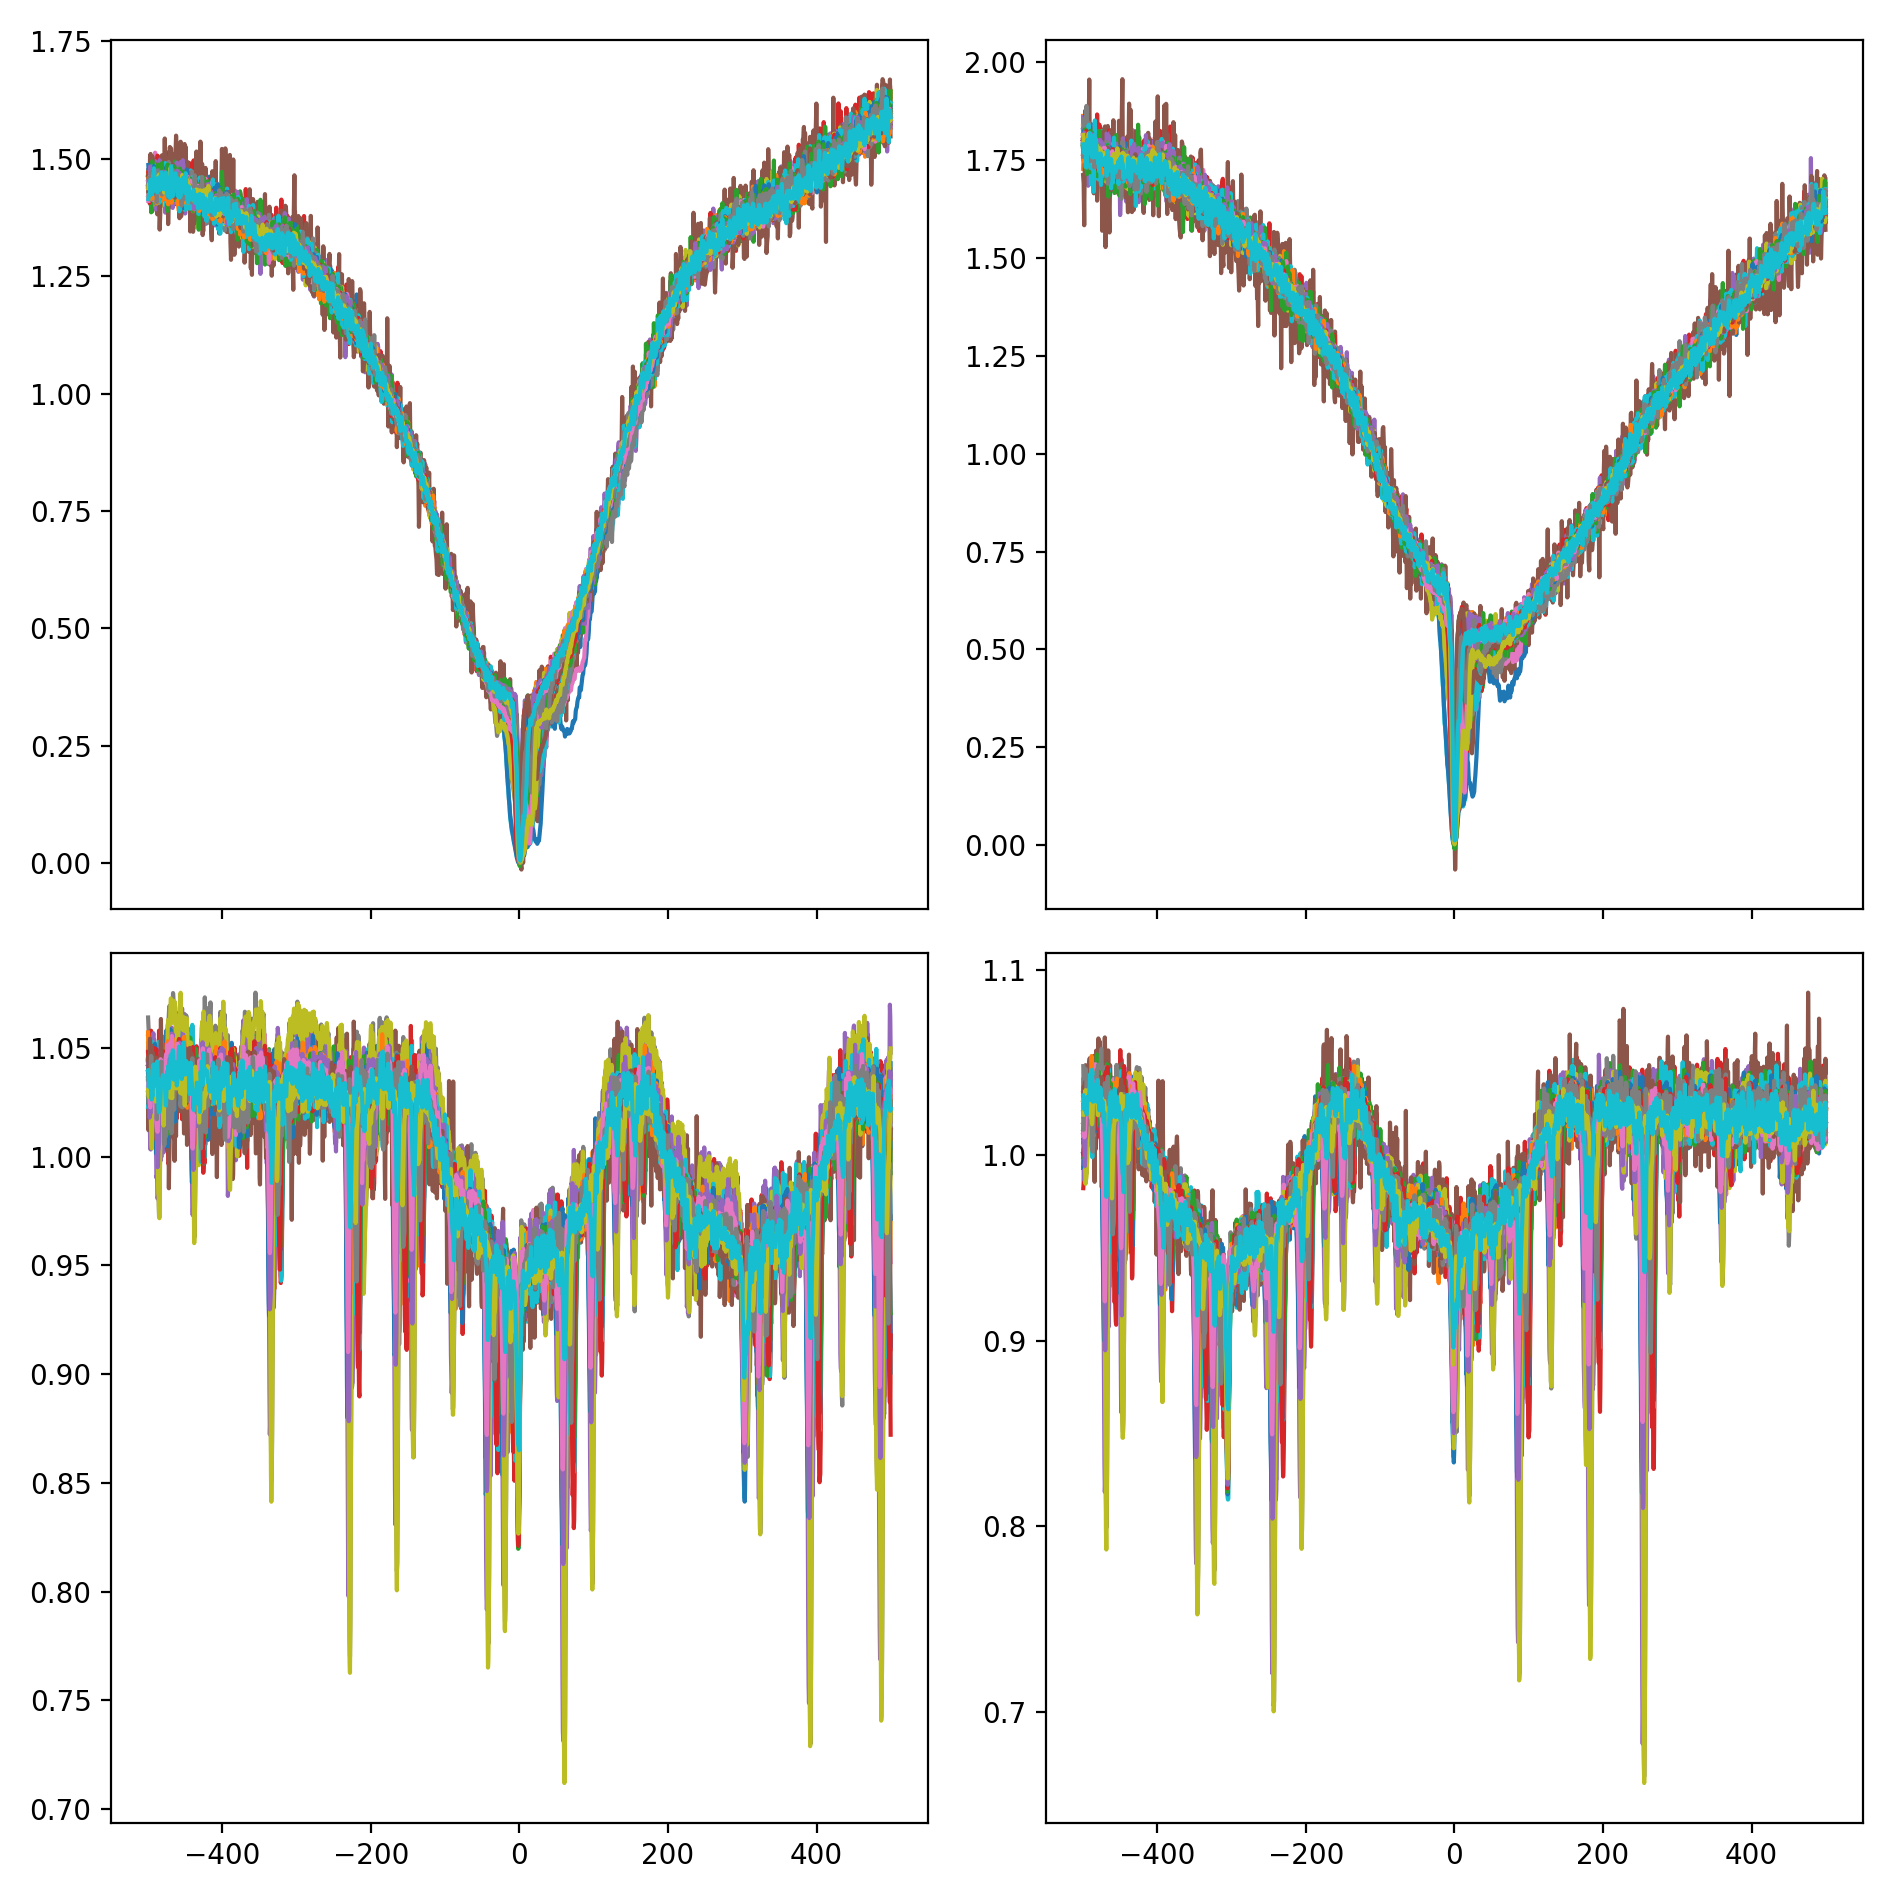

In [4]:
# sample spectra, showing that Ca lines can move while Na lines don't
fig,axs = plt.subplots(2,2,figsize=(9.5,9.5), sharey=False, sharex=True)

for i in np.random.randint(nfiles,size=50):
    f = files[i]
    rv,s,date = get_spec(f)
    axs[0,0].plot(rv,s)
    rv,s,date = get_spec(f,h_not_k=True)
    axs[0,1].plot(rv,s)
    rv,s,date = get_spec(f,sodium=True)
    axs[1,0].plot(rv,s)
    rv,s,date = get_spec(f,sodium=True,h_not_k=True)
    axs[1,1].plot(rv,s)
    
fig.tight_layout()

In [ ]:
# grab all the spectra

# Ca K
rv_ref_ca_k,  _, _ = get_spec(files[0])
rv_ref_ca_h,  _, _ = get_spec(files[0], h_not_k=True)
rv_ref_na_d1, _, _ = get_spec(files[0], sodium=True)
rv_ref_na_d2, _, _ = get_spec(files[0], h_not_k=True, sodium=True)

spec_ca_k = np.array([])
spec_ca_h = np.array([])
spec_na_d1 = np.array([])
spec_na_d2 = np.array([])
dates = np.array([])

for f in files:
    rv,s,d = get_spec(f)
    if not np.allclose(rv,rv_ref_ca_k):
        raise TypeError('Ca K rv different to file zero in {}'.format(f))
    spec_ca_k = np.append(spec_ca_k,s)
    dates = np.append(dates,d)

    rv,s,d = get_spec(f, h_not_k=True)
    if not np.allclose(rv,rv_ref_ca_h):
        raise TypeError('Ca H rv different to file zero in {}'.format(f))
    spec_ca_h = np.append(spec_ca_h,s)

    rv,s,d = get_spec(f, sodium=True)
    if not np.allclose(rv,rv_ref_na_d1):
        raise TypeError('Na D1 rv different to file zero in {}'.format(f))
    spec_na_d1 = np.append(spec_na_d1,s)

    rv,s,d = get_spec(f, sodium=True, h_not_k=True)
    if not np.allclose(rv,rv_ref_na_d2):
        raise TypeError('Na D2 rv different to file zero in {}'.format(f))
    spec_na_d2 = np.append(spec_na_d2,s)

spec_ca_k = spec_ca_k.reshape((len(files),-1))
np.save('allspec-k.npy',spec_ca_k)
np.save('rv-k',rv_ref_ca_k)

spec_ca_h = spec_ca_h.reshape((len(files),-1))
np.save('allspec-h.npy',spec_ca_h)
np.save('rv-h',rv_ref_ca_h)

spec_na_d1 = spec_na_d1.reshape((len(files),-1))
np.save('allspec-d1.npy',spec_na_d1)
np.save('rv-d1',rv_ref_na_d1)

spec_na_d2 = spec_na_d2.reshape((len(files),-1))
np.save('allspec-d2.npy',spec_na_d2)
np.save('rv-d2',rv_ref_na_d2)

np.save('files.npy',files)
np.save('dates.npy',dates)

In [ ]:
# function to create reference spectra
def get_mean_spec(rv, spec):
    # pick a range with no FEBs, and get a linear relation between
    # sqrt(flux) and rms
    ok = np.logical_or(rv < -150, rv > 150)
    rms = np.std(spec[:,ok], axis=0)
    flux = np.mean(spec[:,ok], axis=0)
    fit = np.polyfit(np.sqrt(flux), rms, 1)

    fig,ax = plt.subplots(1,2,figsize=(9.5,5))
    ax[0].plot(np.sqrt(flux), rms, '.')
    ax[0].plot(np.sqrt(flux), np.polyval(fit, np.sqrt(flux)))

    # get the average correction from the 97.5th percentile to the
    # median
    top2p5 = np.percentile(spec, 97.5, axis=0)
    med = np.percentile(spec, 50, axis=0)
    mean_2p5_corr = np.mean(top2p5[ok]/med[ok])
    ax[1].plot(rv[ok], top2p5[ok]/med[ok], '.')
    ax[1].plot([np.min(rv),np.max(rv)],[mean_2p5_corr,mean_2p5_corr])

    # and the mean spectrum
    mean_spec = top2p5 - np.sqrt(top2p5)*np.polyval(fit,np.sqrt(top2p5))
    
    return(mean_spec)

In [ ]:
# create reference spectra, don't bother for Na since lots of telluric lines
mean_spec_ca_k = get_mean_spec(rv_ref_ca_k, spec_ca_k)
mean_spec_ca_h = get_mean_spec(rv_ref_ca_h, spec_ca_h)

In [ ]:
# interpolate across circumstellar lines
n1, n2 = 645, 671
fig,ax = plt.subplots(1,3,figsize=(9.5,5), sharex=False)
ax[0].plot(rv_ref_ca_k, mean_spec_ca_k)
mean_spec_ca_k_nocs = np.array(mean_spec_ca_k)
mean_spec_ca_k_nocs[n1:n2] = mean_spec_ca_k[n1] + \
                               np.arange(n2-n1)/(n2-n1) * (mean_spec_ca_k[n2]-mean_spec_ca_k[n1])
ax[0].plot(rv_ref_ca_k, mean_spec_ca_k_nocs)

for s in spec_ca_k[:10]:
    n = np.std(s/mean_spec_ca_k_nocs)
    if n > .1:
        continue
    ax[1].plot(rv_ref_ca_k, s)
    ax[2].plot(rv_ref_ca_k, s/mean_spec_ca_k_nocs)
ax[1].plot(rv_ref_ca_k, mean_spec_ca_k_nocs, color='b')

ax[0].set_xlim(-100,100)
ax[1].set_xlim(-100,100)
fig.tight_layout()

In [ ]:
# interpolate across circumstellar lines
n1, n2 = 645, 675
fig,ax = plt.subplots(1,3,figsize=(9.5,5), sharex=False)
ax[0].plot(rv_ref_ca_h, mean_spec_ca_h)
mean_spec_ca_h_nocs = np.array(mean_spec_ca_h)
mean_spec_ca_h_nocs[n1:n2] = mean_spec_ca_h[n1] + \
                               np.arange(n2-n1)/(n2-n1) * (mean_spec_ca_h[n2]-mean_spec_ca_h[n1])
ax[0].plot(rv_ref_ca_h, mean_spec_ca_h_nocs)

for s in spec_ca_h[:10]:
    n = np.std(s/mean_spec_ca_h_nocs)
    if n > .1:
        continue
    ax[1].plot(rv_ref_ca_h, s)
    ax[2].plot(rv_ref_ca_h, s/mean_spec_ca_h_nocs)
ax[1].plot(rv_ref_ca_h, mean_spec_ca_h_nocs, color='b')

ax[0].set_xlim(-100,100)
ax[1].set_xlim(-100,100)
fig.tight_layout()

In [29]:
# save mean spectra
np.save('meanspec-k.npy', mean_spec_ca_k)
np.save('meanspec-h.npy', mean_spec_ca_h)

np.save('meanspec-nocs-k.npy',   mean_spec_ca_k_nocs)
np.save('meanspec-nocs-h.npy',   mean_spec_ca_h_nocs)

<IPython.core.display.Javascript object>


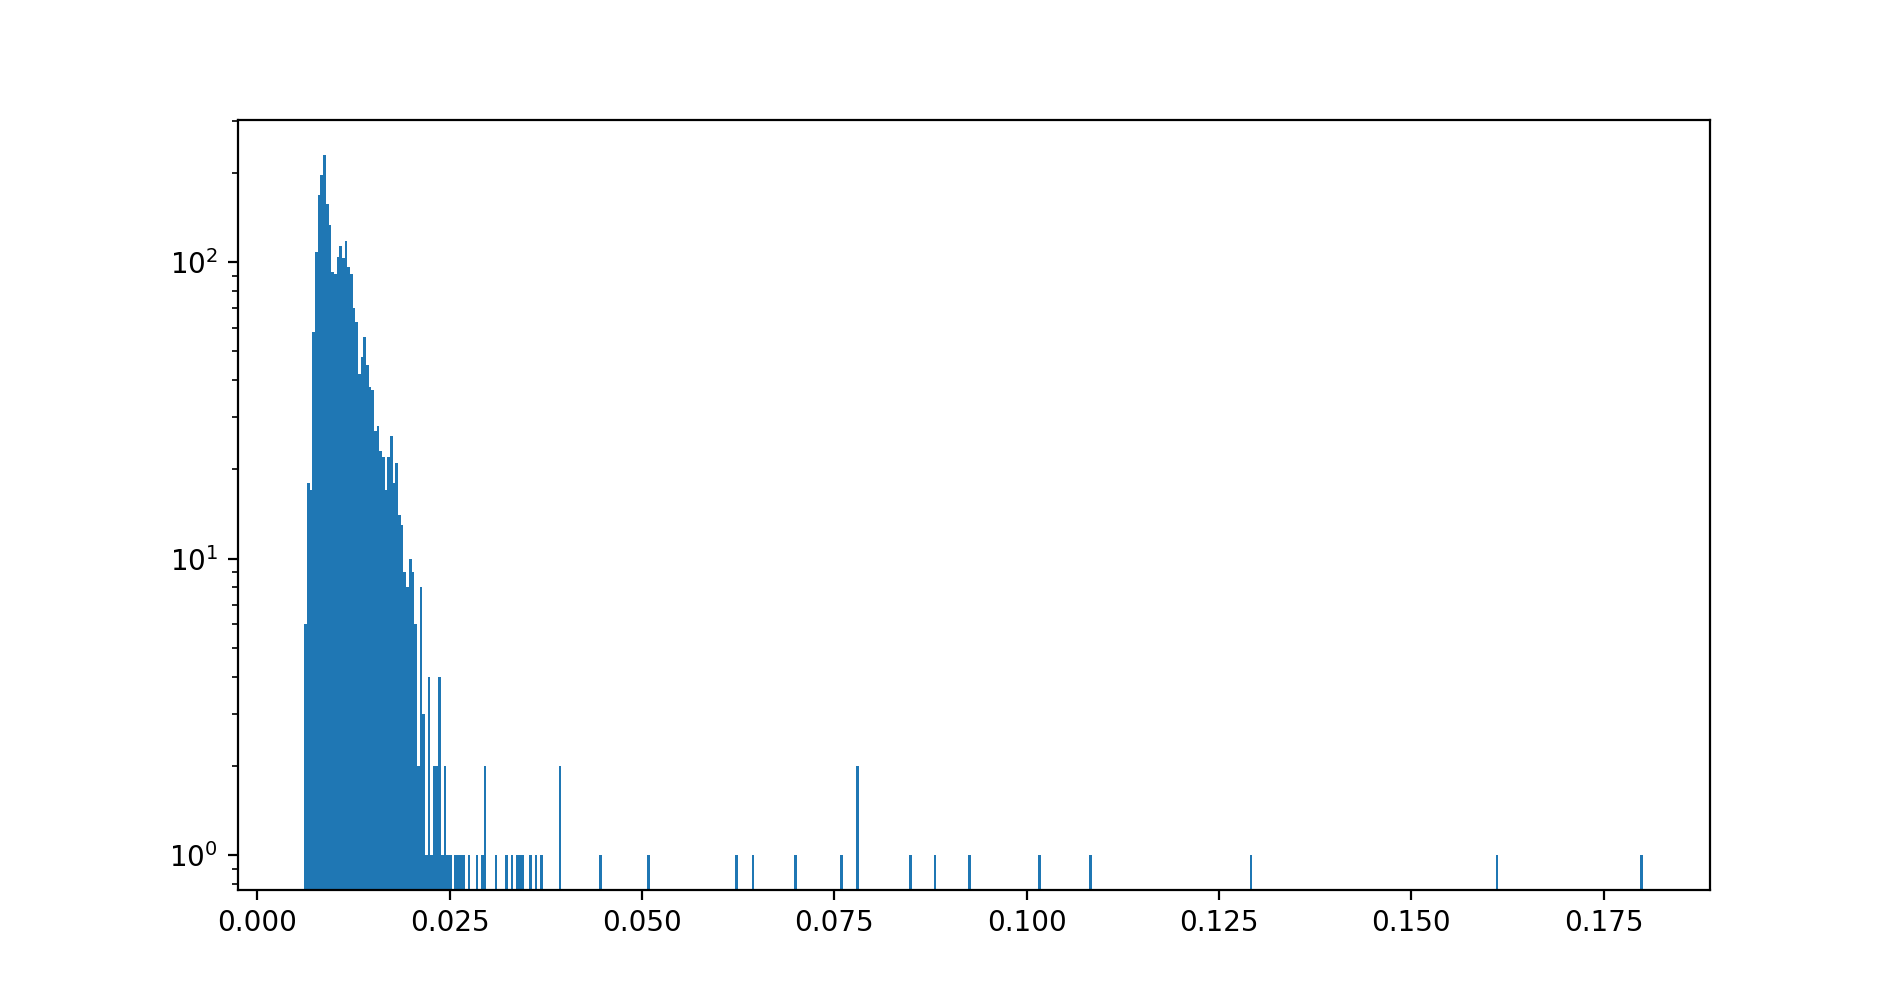

In [34]:
# estimate S/N in each spectrum, near edges of Ca K line (i.e. continuum rms)
std = np.array([])
for s in spec_ca_k:
    ok = np.logical_or(rv_ref_ca_k < -250, rv_ref_ca_k > 250)
    std_tmp = np.std(s[ok] / mean_spec_ca_k[ok])
    std = np.append(std, std_tmp)

fig, ax = plt.subplots(figsize=(9.5,5))
ax.hist(std, bins=500, log=True)
    
np.save('std.npy', std)

# Extras

In [1]:
# additional normalisation step, removing a linear trend
# this didn't remove anything from the time-resolved images
'''
n = 200
lo = np.mean(spec[:,:n])
hi = np.mean(spec[:,-n:])
new_spec = np.array(spec)
for i,s in enumerate(spec):
    lo_tmp = np.mean(s[:n])
    hi_tmp = np.mean(s[-n:])
    norm = np.linspace(lo_tmp/lo, hi_tmp/hi, spec.shape[1])
    new_spec[i] = s / norm
    
spec = new_spec
'''

'\nn = 200\nlo = np.mean(spec[:,:n])\nhi = np.mean(spec[:,-n:])\nnew_spec = np.array(spec)\nfor i,s in enumerate(spec):\n    lo_tmp = np.mean(s[:n])\n    hi_tmp = np.mean(s[-n:])\n    norm = np.linspace(lo_tmp/lo, hi_tmp/hi, spec.shape[1])\n    new_spec[i] = s / norm\n    \nspec = new_spec\n'